In this assignment, we will explore doing Bayesian inference using some Markov Chain Monte Carlo
(MCMC) methods. We will consider the same logistic model that we have looked at in Assignment 2.
This will give you an idea of how you can do Bayesian inference for the same problem with the use of
Markov Chain Monte Carlo methods and give you an idea of a typical Bayesian inference with MCMC
workflow.
The assignment will be due by the end of day on December 15th. Please note that this is a hard
deadline, as final marks need to be in by the noon of Dec 17th. Each question is worth 10 points.
1. Generate some data from the 3-parameter logistic model. Use exactly the same parameter
settings you had as in Assignment 2. However, use N = 200 this time. This will give you a fairly
concentrated posterior. Report on the statistics of this data, i.e., how many 0’s and how many
1’s you observe.


In [5]:
import numpy as np
from scipy.special import expit  # Sigmoid function

# Parameters
N = 200  # New sample size
true_betas = np.array([0.1, 1.1, -0.9])  # (β0, β1, β2)

# Step 1: Generate covariates from Uniform[-2, 2]
np.random.seed(40)  # Set seed for reproducibility
X_covariates = np.random.uniform(-2, 2, (N, 2))

# Add a column of ones for the intercept term
X = np.hstack((np.ones((N, 1)), X_covariates))

# Step 2: Compute probabilities using logistic model
logits = X @ true_betas  # Matrix multiplication (includes intercept term)
probabilities = expit(logits)  # Apply sigmoid to logits

# Step 3: Generate binary responses (y) from Bernoulli distribution
y = np.random.binomial(1, probabilities)

# Report statistics: how many 0's and 1's
zeros = np.sum(y == 0)
ones = np.sum(y == 1)

print(f"Statistics for N={N}:")
print(f"  Number of zeros: {zeros}")
print(f"  Number of ones: {ones}")
print(f"  Proportion of zeros: {zeros / N:.2f}")
print(f"  Proportion of ones: {ones / N:.2f}")

Statistics for N=200:
  Number of zeros: 101
  Number of ones: 99
  Proportion of zeros: 0.51
  Proportion of ones: 0.49


2. Put the same Gaussian priors on the parameters as in Assignment 2. Now, using random-walk
Metropolis-Hastings with a spherical Gaussian proposal, sample from the posterior of the logistic
model with the data you have generated above. Choose the scaling of your proposal so that your
sampler has an acceptance rate of about 23.4%. You can initalize your chain randomly using a
sensible value, for example, that sampled from the prior.
Present trace plots of your parameters starting from the first iteration of the MCMC. Use a
visual inspection of the trace plots to determine what portion to throw away from the start of
the run (this is referred to as the burn-in period) before using the remaining samples to estimate
the posterior mean and posterior standard deviation. Plot histograms displaying your parameter
samples after the burn-in period ends. Make sure the posterior mean and the true value of the
parameter is displayed on the histograms as a vertical line.
Now using M = 20 independent chains started at points sampled from the prior, plot the
running value of the Gelman-Rubin statistic to diagnose convergence. Does the sampler appear
to converge? What iteration does the chain appear to converge after? Is this consistent with the
results of the visual inspection of the trace plots?

Acceptance rate: 0.234


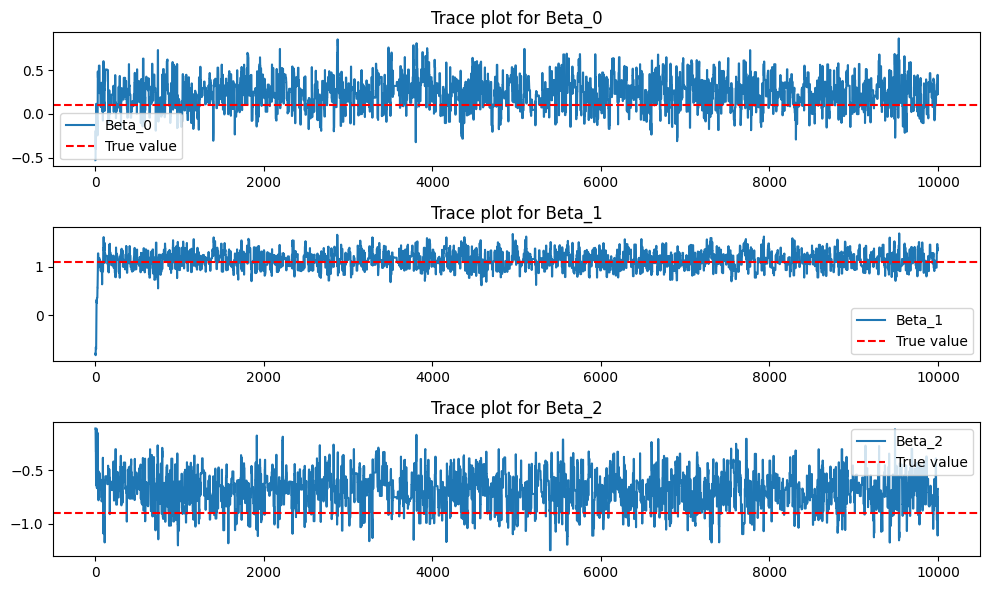

Posterior means: [ 0.23940821  1.13943899 -0.68755987]
Posterior std deviations: [0.17951669 0.16918329 0.16893956]


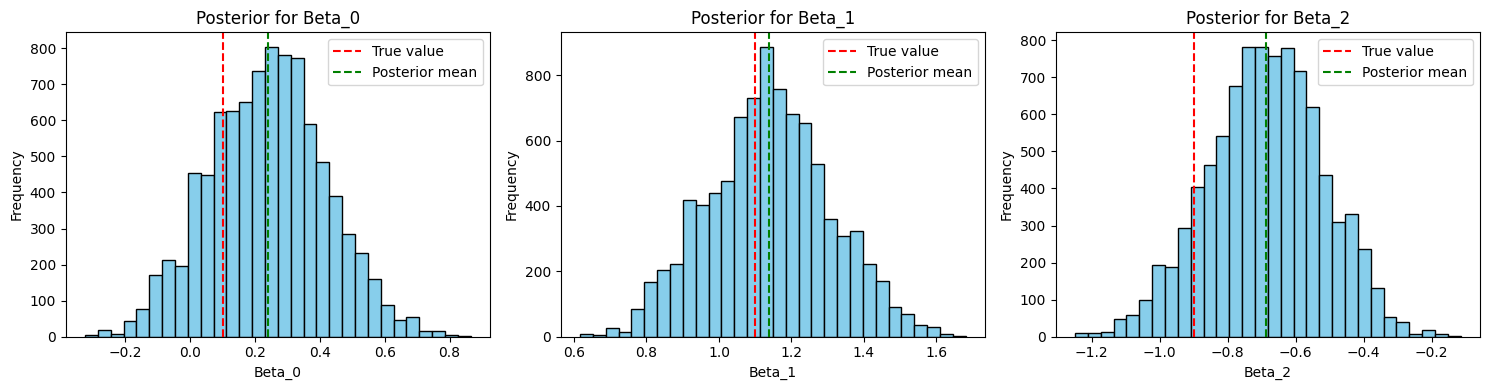

Gelman-Rubin statistics:
<xarray.Dataset> Size: 48B
Dimensions:          (posterior_dim_0: 3)
Coordinates:
  * posterior_dim_0  (posterior_dim_0) int64 24B 0 1 2
Data variables:
    posterior        (posterior_dim_0) float64 24B 1.001 1.002 1.002


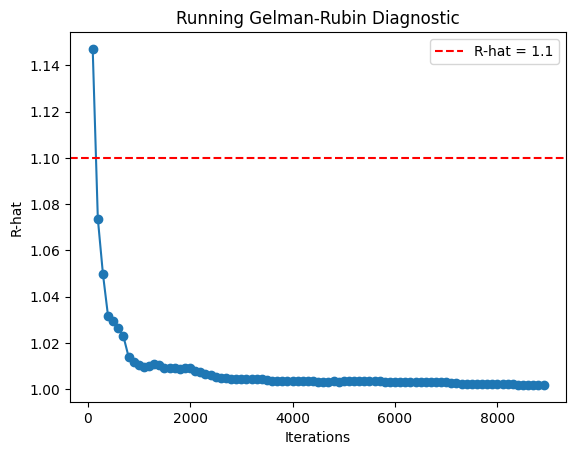

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import arviz as az

# True coefficients for logistic regression
true_betas = np.array([0.1, 1.1, -0.9])

# Sigmoid function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Logistic likelihood
def logistic_likelihood(beta, X, y):
    logits = X @ beta
    probabilities = logistic(logits)
    return np.sum(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities))

# Metropolis-Hastings MCMC

def metropolis_hastings(X, y, prior_mean, prior_cov, proposal_sd, n_samples):
    num_params = len(prior_mean)
    samples = np.zeros((n_samples, num_params))
    acceptance_count = 0

    # Initialize at a random prior sample
    current_beta = np.random.multivariate_normal(prior_mean, prior_cov)
    current_log_post = logistic_likelihood(current_beta, X, y)

    for i in range(n_samples):
        # Propose new beta
        proposed_beta = current_beta + np.random.normal(0, proposal_sd, size=num_params)
        proposed_log_post = logistic_likelihood(proposed_beta, X, y)

        # Calculate acceptance probability
        acceptance_prob = min(1, np.exp(proposed_log_post - current_log_post))

        if np.random.uniform(0, 1) < acceptance_prob:
            current_beta = proposed_beta
            current_log_post = proposed_log_post
            acceptance_count += 1

        samples[i] = current_beta

    acceptance_rate = acceptance_count / n_samples
    return samples, acceptance_rate

# Simulate data
np.random.seed(42)
N = 200  # Sample size
X_covariates = np.random.uniform(-2, 2, (N, len(true_betas) - 1))
X = np.hstack((np.ones((N, 1)), X_covariates))  # Add intercept
logits = X @ true_betas
probabilities = logistic(logits)
y = np.random.binomial(1, probabilities)

# Priors
prior_mean = np.zeros(len(true_betas))
prior_cov = np.eye(len(true_betas))

# Run MCMC
proposal_sd = 0.28 # Adjust this to target 23.4% acceptance rate
n_samples = 10000
samples, acceptance_rate = metropolis_hastings(X, y, prior_mean, prior_cov, proposal_sd, n_samples)
print(f"Acceptance rate: {acceptance_rate:.3f}")

# Trace plots
fig, axes = plt.subplots(len(true_betas), 1, figsize=(10, 6))
for i in range(len(true_betas)):
    axes[i].plot(samples[:, i], label=f"Beta_{i}")
    axes[i].axhline(true_betas[i], color='red', linestyle='--', label="True value")
    axes[i].set_title(f"Trace plot for Beta_{i}")
    axes[i].legend()
plt.tight_layout()
plt.show()

# Burn-in
burn_in = 1000  # Adjust based on trace plot
post_burn_samples = samples[burn_in:]

# Posterior summaries
posterior_means = np.mean(post_burn_samples, axis=0)
posterior_stds = np.std(post_burn_samples, axis=0)
print(f"Posterior means: {posterior_means}")
print(f"Posterior std deviations: {posterior_stds}")

# Histograms
fig, axes = plt.subplots(1, len(true_betas), figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.hist(post_burn_samples[:, i], bins=30, color='skyblue', edgecolor='black')
    ax.axvline(true_betas[i], color='red', linestyle='--', label="True value")
    ax.axvline(posterior_means[i], color='green', linestyle='--', label="Posterior mean")
    ax.set_title(f"Posterior for Beta_{i}")
    ax.set_xlabel(f"Beta_{i}")
    ax.set_ylabel("Frequency")
    ax.legend()
plt.tight_layout()
plt.show()

# Gelman-Rubin diagnostic
num_chains = 20
chain_samples = []
for _ in range(num_chains):
    chain, _ = metropolis_hastings(X, y, prior_mean, prior_cov, proposal_sd, n_samples)
    chain_samples.append(chain[burn_in:])

chain_samples = np.array(chain_samples)  # Shape: (num_chains, num_samples, num_params)

# Convert to ArviZ InferenceData
inference_data = az.convert_to_inference_data({"posterior": chain_samples})

# Gelman-Rubin statistic
rhat = az.rhat(inference_data)
print("Gelman-Rubin statistics:")
print(rhat)

# Plot running Gelman-Rubin statistics
rhat_values = []
for i in range(100, chain_samples.shape[1], 100):  # Compute R-hat every 200 iterations
    truncated_data = az.convert_to_inference_data({"posterior": chain_samples[:, :i, :]})
    rhat_values.append(az.rhat(truncated_data).to_array().values.max())

plt.plot(range(100, chain_samples.shape[1], 100), rhat_values, marker='o')
plt.axhline(1.1, color='red', linestyle='--', label='R-hat = 1.1')
plt.title("Running Gelman-Rubin Diagnostic")
plt.xlabel("Iterations")
plt.ylabel("R-hat")
plt.legend()
plt.show()

3. Now, increase the dimensionality of your problem to 9 as you did in Assignment 2 and use
N = 200. Please report the values of the all parameters that your model is now using. Repeat
the analysis in Question 2. How much did you have to decrease the scaling of your proposal to
maintain the aimed for acceptance rate of 23.4 percent?

Acceptance rate: 0.236


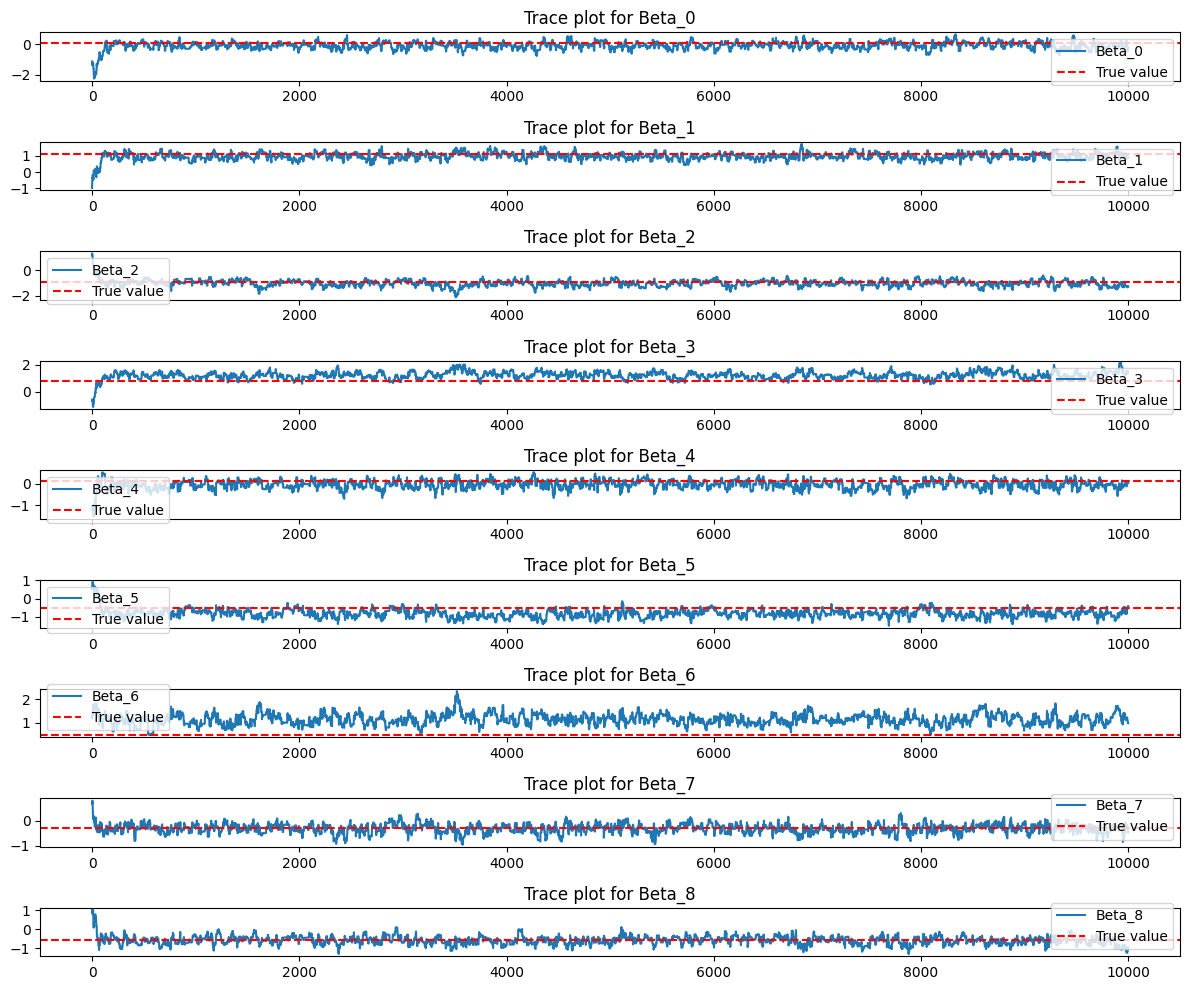

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import arviz as az

# True coefficients for logistic regression (9 parameters)
true_betas = np.array([0.1, 1.1, -0.9, 0.77536459, 0.11476865, -0.51065242,
                       0.49753524, -0.27748801, -0.56034187])

# Logistic function
def logistic(x):
    return 1 / (1 + np.exp(-x))

# Logistic likelihood function
def logistic_likelihood(beta, X, y):
    logits = X @ beta
    probabilities = logistic(logits)
    return np.sum(y * np.log(probabilities) + (1 - y) * np.log(1 - probabilities))

# Metropolis-Hastings MCMC
def metropolis_hastings(X, y, prior_mean, prior_cov, proposal_sd, n_samples):
    num_params = len(prior_mean)
    samples = np.zeros((n_samples, num_params))
    acceptance_count = 0

    # Initialize at a random sample from the prior
    current_beta = np.random.multivariate_normal(prior_mean, prior_cov)
    current_log_post = logistic_likelihood(current_beta, X, y)

    for i in range(n_samples):
        # Propose new beta
        proposed_beta = current_beta + np.random.normal(0, proposal_sd, size=num_params)
        proposed_log_post = logistic_likelihood(proposed_beta, X, y)

        # Calculate acceptance probability
        acceptance_prob = min(1, np.exp(proposed_log_post - current_log_post))

        if np.random.uniform(0, 1) < acceptance_prob:
            current_beta = proposed_beta
            current_log_post = proposed_log_post
            acceptance_count += 1

        samples[i] = current_beta

    acceptance_rate = acceptance_count / n_samples
    return samples, acceptance_rate

# Simulate data with 9 parameters
np.random.seed(42)
N = 200  # Sample size
X_covariates = np.random.uniform(-2, 2, (N, len(true_betas) - 1))  # Generate covariates
X = np.hstack((np.ones((N, 1)), X_covariates))  # Add intercept
logits = X @ true_betas
probabilities = logistic(logits)
y = np.random.binomial(1, probabilities)  # Generate binary responses

# Priors
prior_mean = np.zeros(len(true_betas))
prior_cov = np.eye(len(true_betas))

# Run MCMC
proposal_sd = 0.16  # Start with a reasonable value for proposal SD
n_samples = 10000
samples, acceptance_rate = metropolis_hastings(X, y, prior_mean, prior_cov, proposal_sd, n_samples)
print(f"Acceptance rate: {acceptance_rate:.3f}")

# Trace plots
fig, axes = plt.subplots(len(true_betas), 1, figsize=(12, 10))
for i in range(len(true_betas)):
    axes[i].plot(samples[:, i], label=f"Beta_{i}")
    axes[i].axhline(true_betas[i], color='red', linestyle='--', label="True value")
    axes[i].set_title(f"Trace plot for Beta_{i}")
    axes[i].legend()
plt.tight_layout()
plt.show()

Posterior means: [-0.06211918  0.99061282 -1.0298192   1.23108241 -0.04103489 -0.82994812
  1.15697916 -0.31151614 -0.58949416]
Posterior std deviations: [0.21955985 0.19531973 0.23190805 0.25298263 0.18956139 0.2017392
 0.22229232 0.18737947 0.20756728]


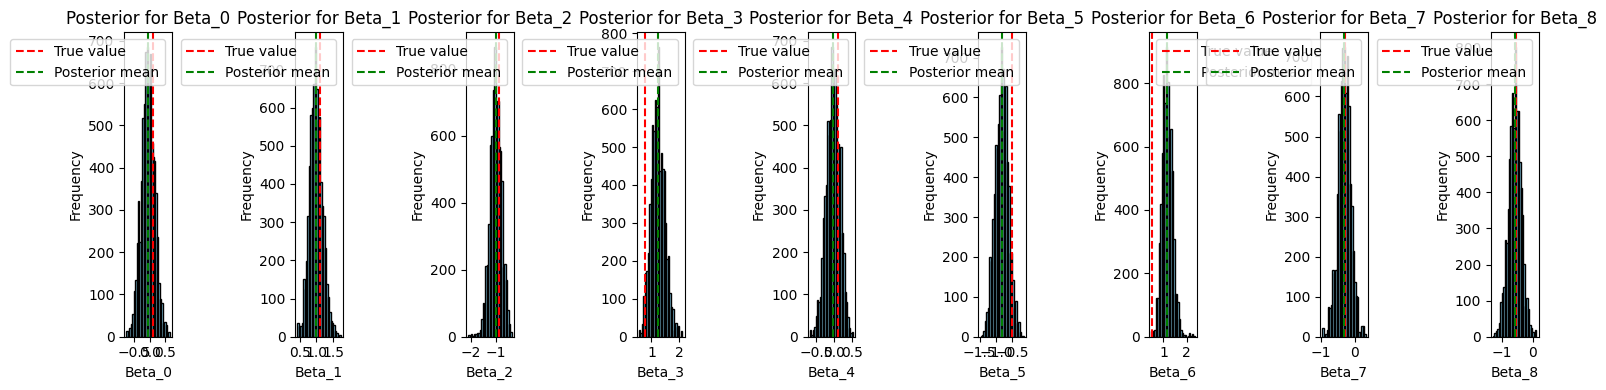

Gelman-Rubin statistics:
<xarray.Dataset> Size: 144B
Dimensions:          (posterior_dim_0: 9)
Coordinates:
  * posterior_dim_0  (posterior_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
Data variables:
    posterior        (posterior_dim_0) float64 72B 1.006 1.007 ... 1.005 1.007


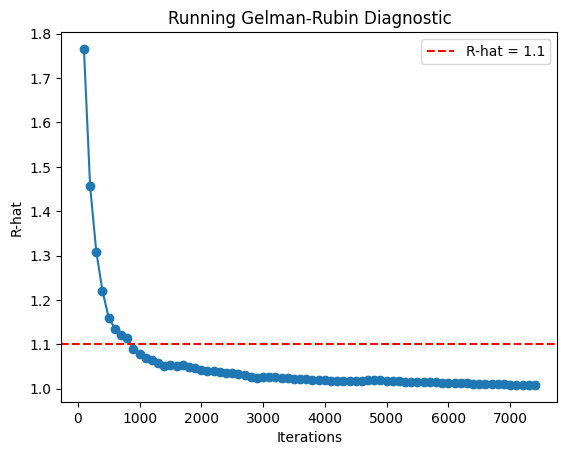

In [4]:
burn_in = 2500  # Adjust based on trace plot
post_burn_samples = samples[burn_in:]

# Posterior summaries
posterior_means = np.mean(post_burn_samples, axis=0)
posterior_stds = np.std(post_burn_samples, axis=0)
print(f"Posterior means: {posterior_means}")
print(f"Posterior std deviations: {posterior_stds}")

# Histograms
fig, axes = plt.subplots(1, len(true_betas), figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.hist(post_burn_samples[:, i], bins=30, color='skyblue', edgecolor='black')
    ax.axvline(true_betas[i], color='red', linestyle='--', label="True value")
    ax.axvline(posterior_means[i], color='green', linestyle='--', label="Posterior mean")
    ax.set_title(f"Posterior for Beta_{i}")
    ax.set_xlabel(f"Beta_{i}")
    ax.set_ylabel("Frequency")
    ax.legend()
plt.tight_layout()
plt.show()

# Gelman-Rubin diagnostic
num_chains = 20
chain_samples = []
for _ in range(num_chains):
    chain, _ = metropolis_hastings(X, y, prior_mean, prior_cov, proposal_sd, n_samples)
    chain_samples.append(chain[burn_in:])

chain_samples = np.array(chain_samples)  # Shape: (num_chains, num_samples, num_params)

# Convert to ArviZ InferenceData
inference_data = az.convert_to_inference_data({"posterior": chain_samples})

# Gelman-Rubin statistic
rhat = az.rhat(inference_data)
print("Gelman-Rubin statistics:")
print(rhat)

# Plot running Gelman-Rubin statistics
rhat_values = []
for i in range(100, chain_samples.shape[1], 100):  # Compute R-hat every 200 iterations
    truncated_data = az.convert_to_inference_data({"posterior": chain_samples[:, :i, :]})
    rhat_values.append(az.rhat(truncated_data).to_array().values.max())

plt.plot(range(100, chain_samples.shape[1], 100), rhat_values, marker='o')
plt.axhline(1.1, color='red', linestyle='--', label='R-hat = 1.1')
plt.title("Running Gelman-Rubin Diagnostic")
plt.xlabel("Iterations")
plt.ylabel("R-hat")
plt.legend()
plt.show()

4. While we cannot compute conditionals of the β parameters exactly, we can still cycle through
the conditionals one at a time by using a Metropolis-Hastings update to draw a sample from
each conditional in turn. This is known as “Metropolis-within-Gibbs” (MWG). Apply MWG to
the 9-dimensional problem, tuning the acceptance rate on each sampler from a conditional to
about 15%. Plot the Gelman-Rubin statistic for M = 10 chains. Does this sampler appear to
work better than Metropolis? Does the Gelman-Rubin statistic go to 1 faster?


True parameter values:
[ 0.1         1.1        -0.9         0.77536459  0.11476865 -0.51065242
  0.49753524 -0.27748801 -0.56034187]

Data Statistics:
Zeros: 92, Proportion: 0.46
Ones: 108, Proportion: 0.54

Mean acceptance rates per parameter:
[0.14585 0.1368  0.12661 0.13239 0.12616 0.12521 0.12642 0.12224 0.12477]


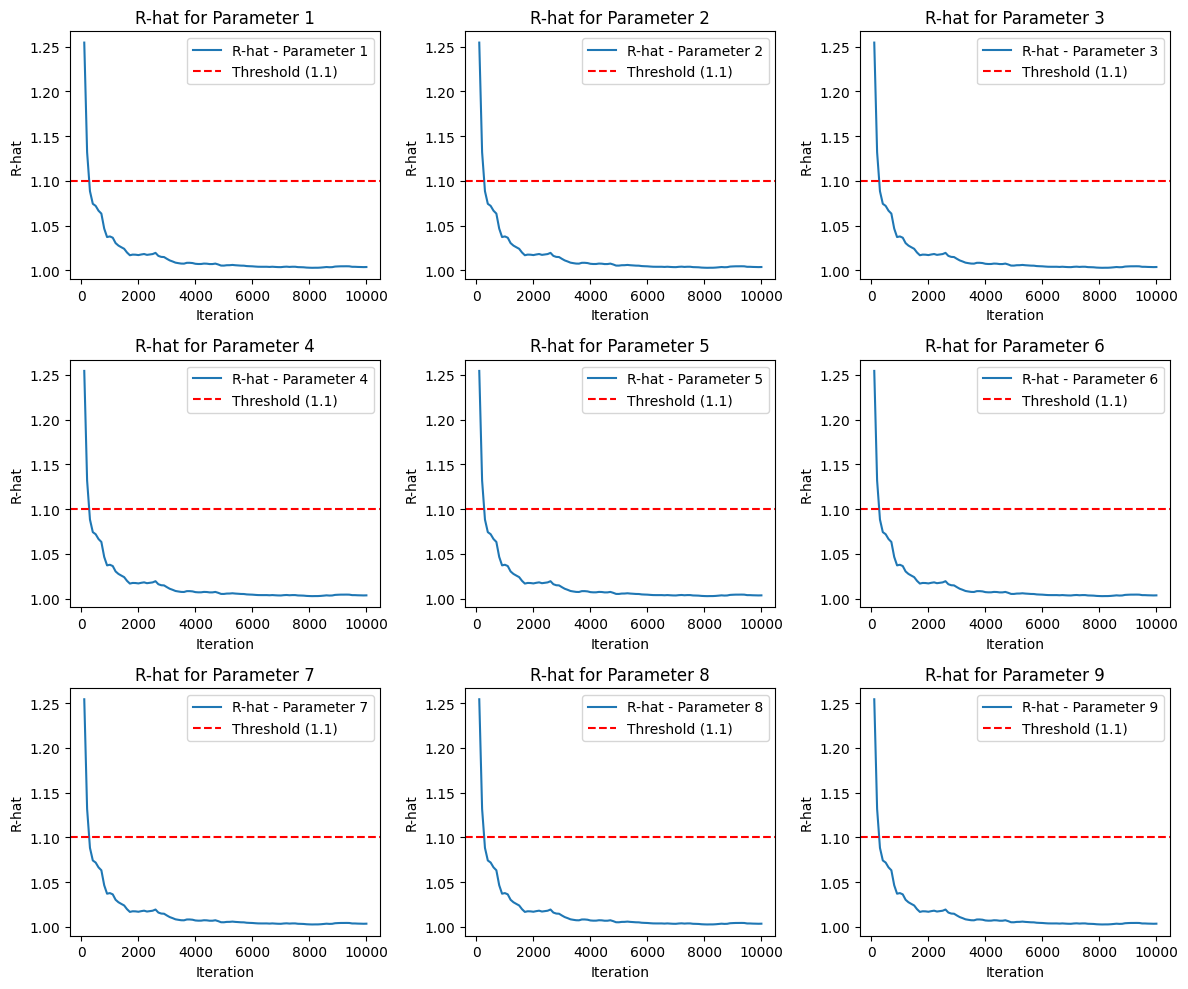


Posterior Summaries:
Parameter 1: Mean = 0.646, SD = 0.226
Parameter 2: Mean = 1.246, SD = 0.230
Parameter 3: Mean = -1.015, SD = 0.199
Parameter 4: Mean = 0.458, SD = 0.202
Parameter 5: Mean = -0.103, SD = 0.190
Parameter 6: Mean = -0.751, SD = 0.207
Parameter 7: Mean = 0.995, SD = 0.202
Parameter 8: Mean = -0.420, SD = 0.187
Parameter 9: Mean = -0.876, SD = 0.207


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import arviz as az

# Data Generation
np.random.seed(40)
N = 200
initial_betas = np.array([0.1, 1.1, -0.9])
additional_betas = np.array([0.77536459, 0.11476865, -0.51065242, 0.49753524, -0.27748801, -0.56034187])
true_betas = np.concatenate([initial_betas, additional_betas])
print("True parameter values:")
print(true_betas)

X_covariates = np.random.uniform(-2, 2, (N, 8))
X = np.hstack((np.ones((N, 1)), X_covariates))
probabilities = 1 / (1 + np.exp(-X @ true_betas))
y = np.random.binomial(1, probabilities)

zeros = np.sum(y == 0)
ones = np.sum(y == 1)
print("\nData Statistics:")
print(f"Zeros: {zeros}, Proportion: {zeros / N:.2f}")
print(f"Ones: {ones}, Proportion: {ones / N:.2f}")

# Metropolis-within-Gibbs
n_iter = 10000
n_chains = 10
n_params = 9
prior_mean = np.zeros(n_params)
prior_sd = 2
proposal_sds = np.full(n_params, 1.8)  # Tuned for ~15% acceptance rate

def log_conditional(beta_prop, beta_current, param_idx, X, y, prior_mean, prior_sd):
    beta_temp = beta_current.copy()
    beta_temp[param_idx] = beta_prop
    linear_pred = X @ beta_temp
    log_lik = np.sum(y * linear_pred - np.log(1 + np.exp(linear_pred)))
    log_prior = norm.logpdf(beta_prop, loc=prior_mean[param_idx], scale=prior_sd)
    return log_lik + log_prior

chains = np.zeros((n_iter, n_params, n_chains))
acceptance_counts = np.zeros((n_chains, n_params))

for chain in range(n_chains):
    beta_current = np.random.normal(prior_mean, prior_sd)
    for i in range(n_iter):
        for j in range(n_params):
            beta_proposal = beta_current[j] + np.random.normal(0, proposal_sds[j])
            log_r = (log_conditional(beta_proposal, beta_current, j, X, y, prior_mean, prior_sd) -
                     log_conditional(beta_current[j], beta_current, j, X, y, prior_mean, prior_sd))
            if np.log(np.random.uniform()) < log_r:
                beta_current[j] = beta_proposal
                acceptance_counts[chain, j] += 1
        chains[i, :, chain] = beta_current

acceptance_rates = acceptance_counts / n_iter
mean_rates = acceptance_rates.mean(axis=0)
print("\nMean acceptance rates per parameter:")
print(mean_rates)

# Gelman-Rubin diagnostics
assessment_points = np.arange(100, n_iter + 1, 100)
rhat_values = np.zeros((len(assessment_points), n_params))

for idx, point in enumerate(assessment_points):
    truncated_chains = chains[:point, :, :]
    mcmc_list = [truncated_chains[:, :, chain] for chain in range(n_chains)]
    inference_data = az.convert_to_inference_data({"posterior": np.stack(mcmc_list, axis=0)})
    rhat = az.rhat(inference_data).to_array().values
    rhat_values[idx, :] = rhat.max(axis=1)

plt.figure(figsize=(12, 10))
for i in range(n_params):
    plt.subplot(3, 3, i + 1)
    plt.plot(assessment_points, rhat_values[:, i], label=f"R-hat - Parameter {i + 1}")
    plt.axhline(1.1, color='red', linestyle='--', label="Threshold (1.1)")
    plt.title(f"R-hat for Parameter {i + 1}")
    plt.xlabel("Iteration")
    plt.ylabel("R-hat")
    plt.legend()
plt.tight_layout()
plt.show()

# Posterior Summaries
burn_in = 1000
chains_burned = chains[burn_in:, :, :]
posterior_means = chains_burned.mean(axis=(0, 2))
posterior_sds = chains_burned.std(axis=(0, 2))

print("\nPosterior Summaries:")
for i in range(n_params):
    print(f"Parameter {i + 1}: Mean = {posterior_means[i]:.3f}, SD = {posterior_sds[i]:.3f}")

5. Finally, in the 9 dimensional problem, try randomly choosing a proposal (with probability 1/2)
that uses either a standard deviation that corresponds to a 10% acceptance rate or a standard
deviation that corresponds to a 30% acceptance rate. Does this sampler converge to stationarity
faster? Take a look for M = 20 chains at points sampled from the prior how quickly the value
of the Gelman-Rubin statistic goes to 1